# Week 01 — Distribution & KPI Sense (분포/대표값/이상치)

이 노트북은 **실전 통계 → 해석 → 비즈니스 액션**을 훈련하기 위한 템플릿입니다.
각 섹션의 ✅ 체크포인트를 채우면서 진행하세요.


## 1) Business Questions
- 평균 매출이 늘었는데 체감이 없다면 분포(상위 소수/이상치) 때문인가?
- 국가/채널/세그먼트별로 Mean vs Median 차이가 큰 곳은 어디인가?
- KPI를 Median/P75로 재정의하면 인사이트가 달라지는가?

## 2) Why this matters (Theory)
- Skewed distribution에서 Mean은 상위 소수에 과도하게 영향을 받음
- Median/P75는 'typical customer' 혹은 '상위 안정 구간'을 더 잘 설명
- 이상치는 오류가 아니라 '비즈니스 이벤트'일 수 있음

## 3) Setup & Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

DATA_PATH = "data/sales_marketing_example_2025.csv"
df = pd.read_csv(DATA_PATH, parse_dates=["date"])

# Quick sanity checks
display(df.head())
print("rows, cols:", df.shape)
print("missing rate (top):")
display(df.isna().mean().sort_values(ascending=False).head(10))

,date,country,channel,segment,campaign,marketing_spend,impressions,clicks,leads,sales_calls,discount_rate,conversions,revenue,gross_margin
0,2025-01-01,SG,Ecommerce,Mid,A,157.59,14352,361,27,1,0.0257,0,0.00,0.00
1,2025-01-01,KR,Direct,Mid,A,216.07,16197,224,18,3,0.0852,0,0.00,0.00
2,2025-01-01,KR,Ecommerce,SMB,A,105.45,7543,119,14,0,0.0433,0,0.00,0.00
3,2025-01-01,SG,Ecommerce,SMB,C,106.82,9003,187,18,1,0.0489,1,1084.93,601.91
4,2025-01-01,JP,Ecommerce,Mid,NaN,69.22,5515,107,5,0,0.0455,0,0.00,0.00


rows, cols: (12000, 14)
missing rate (top):


campaign           0.539500
marketing_spend    0.014917
country            0.000000
date               0.000000
segment            0.000000
channel            0.000000
impressions        0.000000
clicks             0.000000
leads              0.000000
sales_calls        0.000000
dtype: float64

## 4) Helper Functions

In [14]:
def one_sentence_insight(prompt: str):
    """Write your one-sentence business insight below."""
    print("\n🧾 One-sentence insight (fill this):")
    print(" -", prompt)

def bootstrap_mean_diff(x, y, iters=5000, seed=0):
    """Bootstrap CI for difference in means (x - y)."""
    r = np.random.default_rng(seed)
    x = np.asarray(pd.Series(x).fillna(0))
    y = np.asarray(pd.Series(y).fillna(0))
    diffs = []
    for _ in range(iters):
        xs = r.choice(x, size=len(x), replace=True)
        ys = r.choice(y, size=len(y), replace=True)
        diffs.append(xs.mean() - ys.mean())
    diffs = np.array(diffs)
    return diffs.mean(), np.quantile(diffs, [0.025, 0.975])

def rate_ci_wilson(successes, n, alpha=0.05):
    """Wilson score interval for a proportion."""
    if n == 0:
        return (np.nan, np.nan)
    z = stats.norm.ppf(1 - alpha/2)
    phat = successes / n
    denom = 1 + z**2/n
    center = (phat + z**2/(2*n)) / denom
    half = z * np.sqrt((phat*(1-phat) + z**2/(4*n)) / n) / denom
    return center - half, center + half

---
## 5) Analysis

### 5.1 Revenue distribution (clipped) & summary stats
✅ 매출 분포를 보고 **Mean/Median/P75/P90**를 비교하세요.

array(['SG', 'KR', 'JP', 'TW', 'ANZ', 'HK'], dtype=object)

In [30]:
ax.flatten()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)


📊 Revenue distribution for country: SG

📊 Revenue distribution for country: KR

📊 Revenue distribution for country: JP

📊 Revenue distribution for country: TW

📊 Revenue distribution for country: ANZ

📊 Revenue distribution for country: HK


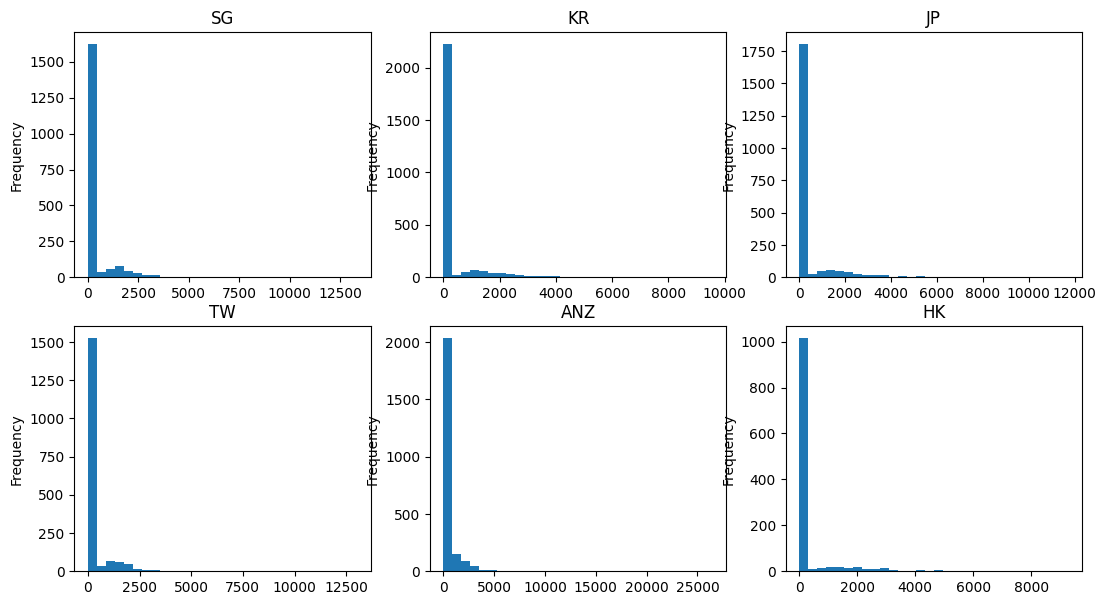

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(13,7))
for i, country in enumerate(df["country"].unique()):
    # print(f"\n📊 Revenue distribution for country: {country}")
    df[df["country"] == country]["revenue"].plot(kind='hist',ax=ax.flatten()[i], title=country, bins=30)

## some big customer affect average purchase amt

Mean: 303.046385
Median: 0.0
P75: 0.0 P90: 1310.4450000000004 P99: 4064.8008000000013


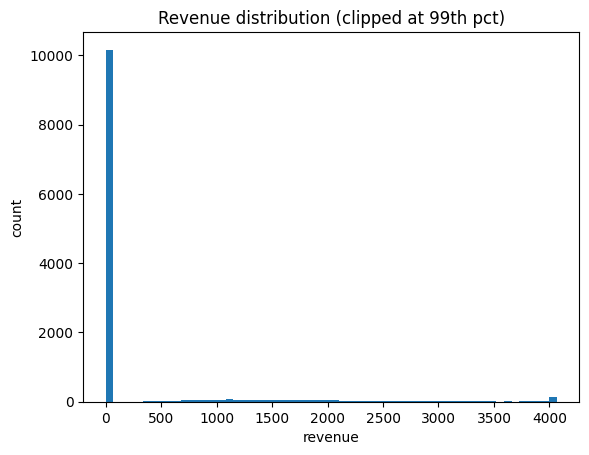

In [12]:
x = df['revenue'].fillna(0)
print("Mean:", x.mean())
print("Median:", x.median())
print("P75:", x.quantile(0.75), "P90:", x.quantile(0.90), "P99:", x.quantile(0.99))

plt.figure()
plt.hist(x.clip(upper=x.quantile(0.99)), bins=60)
plt.title("Revenue distribution (clipped at 99th pct)")
plt.xlabel("revenue")
plt.ylabel("count")
plt.show()

In [15]:
one_sentence_insight('Mean과 Median이 벌어지는 이유(상위 소수 vs 일반 고객)를 한 문장으로 정리')


🧾 One-sentence insight (fill this):
 - Mean과 Median이 벌어지는 이유(상위 소수 vs 일반 고객)를 한 문장으로 정리


### 5.2 Segment matrix (country × channel) with Mean vs Median
✅ Mean과 Median이 크게 다른 조합을 찾아 원인을 추정하세요.

In [65]:
g = (df.assign(revenue=df['revenue'].fillna(0))
       .groupby(['country','channel'])
       .agg(n=('revenue','size'),
            revenue_sum=('revenue','sum'),
            revenue_mean=('revenue','mean'),
            revenue_median=('revenue','median'),
            revenue_p95=('revenue', lambda s: (s[s>=s.quantile(0.95)]).mean()),
            revenue_p90=('revenue', lambda s: (s[s>=s.quantile(0.90)]).mean()),
            revenue_p80=('revenue', lambda s: (s[s>=s.quantile(0.80)]).mean()),
            revenue_p70=('revenue', lambda s: (s[s>=s.quantile(0.70)]).mean()),
            conv_rate=('conversions','mean'),
            spend_mean=('marketing_spend','mean'))
       .reset_index())

g['mean_minus_median'] = g['revenue_mean'] - g['revenue_median']
g["pct_mean_minus_median"] = g["mean_minus_median"] / g["revenue_mean"].replace(0, np.nan)*100
display(g.sort_values(['country','revenue_sum'], ascending=[False, False]).head(15))

,country,channel,n,revenue_sum,revenue_mean,revenue_median,revenue_p95,revenue_p90,revenue_p80,revenue_p70,conv_rate,spend_mean,mean_minus_median,pct_mean_minus_median
20,TW,Direct,631,193490.09,306.640396,0.0,2953.012187,2272.651875,306.640396,306.640396,0.177496,93.367316,306.640396,100.0
22,TW,Ecommerce,480,135295.37,281.865354,0.0,3238.922917,2433.100417,281.865354,281.865354,0.145833,99.077286,281.865354,100.0
21,TW,Distributor,442,80915.82,183.067466,0.0,2307.140870,1730.726444,183.067466,183.067466,0.115385,66.705309,183.067466,100.0
23,TW,SupplyHouse,230,45428.09,197.513435,0.0,2623.764167,1892.186522,197.513435,197.513435,0.113043,80.698634,197.513435,100.0
16,SG,Direct,681,287266.90,421.830984,0.0,3828.596857,2908.956812,2070.067299,421.830984,0.212922,93.017852,421.830984,100.0
18,SG,Ecommerce,492,149348.27,303.553394,0.0,3403.720000,2495.392200,303.553394,303.553394,0.156504,107.915667,303.553394,100.0
17,SG,Distributor,451,102561.16,227.408337,0.0,2751.819565,2119.648261,227.408337,227.408337,0.117517,70.592619,227.408337,100.0
19,SG,SupplyHouse,300,59314.78,197.715933,0.0,2766.762667,1931.653667,197.715933,197.715933,0.110000,72.323153,197.715933,100.0
12,KR,Direct,905,330373.56,365.053657,0.0,3385.828478,2640.619121,365.053657,365.053657,0.191160,93.811700,365.053657,100.0
14,KR,Ecommerce,682,214946.07,315.170191,0.0,3428.651143,2570.058986,315.170191,315.170191,0.159824,113.225282,315.170191,100.0


In [66]:
one_sentence_insight('Mean- Median gap이 큰 상위 1~2개 그룹을 고르고, KPI를 어떻게 바꿀지 제안')


🧾 One-sentence insight (fill this):
 - Mean- Median gap이 큰 상위 1~2개 그룹을 고르고, KPI를 어떻게 바꿀지 제안


### 5.3 Outlier review: top 0.5% revenue rows
✅ 이상치는 제거 대상이 아니라 **설명 대상**입니다.

In [67]:
q995 = df['revenue'].fillna(0).quantile(0.995)
out = df[df['revenue'].fillna(0) >= q995][['date','country','channel','segment','campaign','revenue','gross_margin','discount_rate']]
display(out.head(20))
print("outlier share of total revenue:", out['revenue'].sum() / df['revenue'].fillna(0).sum()*100,"%")

,date,country,channel,segment,campaign,revenue,gross_margin,discount_rate
69,2025-01-03,ANZ,Direct,Enterprise,NaN,5907.55,2707.70,0.1297
77,2025-01-03,ANZ,Ecommerce,Mid,NaN,5827.36,3128.30,0.0358
89,2025-01-03,KR,Distributor,Enterprise,NaN,8275.38,3814.13,0.0164
118,2025-01-04,HK,Direct,Mid,C,5962.65,3490.72,0.0143
330,2025-01-11,TW,Direct,SMB,B,7702.43,3641.41,0.0417
441,2025-01-15,JP,SupplyHouse,Enterprise,NaN,6042.16,2928.53,0.0266
648,2025-01-21,JP,SupplyHouse,SMB,NaN,11732.92,5943.66,0.0233
905,2025-01-29,ANZ,Ecommerce,Enterprise,A,5256.31,2536.44,0.0615
1136,2025-02-05,TW,Ecommerce,Mid,A,6369.83,3384.35,0.0888
1405,2025-02-13,ANZ,SupplyHouse,Enterprise,B,6057.12,2778.34,0.0779


outlier share of total revenue: 11.47044480775883 %


In [68]:
one_sentence_insight('상위 0.5%가 전체 매출에서 차지하는 비중을 보고 KPI/리포팅 관점에서 한 문장')


🧾 One-sentence insight (fill this):
 - 상위 0.5%가 전체 매출에서 차지하는 비중을 보고 KPI/리포팅 관점에서 한 문장


---
## 6) Interpretation Checklist
- 결과가 '유의'하면, **효과 크기/CI**가 실무적으로 의미 있는가?
- 결과가 '비유의'하면, **표본 부족/측정오류/세그먼트 혼합** 가능성은?
- 액션을 한다면, **누구에게/어디에/얼마나** 적용할 것인가?



## Executive Summary (메일/슬라이드에 그대로 붙여넣기)

- **핵심 질문:**  
- **결론(한 문장):**  
- **근거 지표:** (효과크기 / p-value / CI 등)  
- **비즈니스 임팩트:** (예: 월 매출 +X, 마진 -Y 위험)  
- **권장 액션:** (실험/타겟 변경/채널 믹스 조정)  
- **추가 분석 필요:**  
